In [6]:
import os

import torch
import numpy as np

In [2]:
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262)
transform_train_proper = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        ])
transform_blurred = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize(8, interpolation=InterpolationMode.BILINEAR, antialias=None), 
    transforms.Resize(32, interpolation=InterpolationMode.BILINEAR, antialias=None),
    transforms.Normalize(mean, std)
    ])

In [7]:
from src.utils.common import DATASET_NAME_MAP
DATASET_NAME = 'cifar10'

def get_held_out_data(dataset_name, nb_samples_per_class=50):
    _, test_proper_dataset, _ = DATASET_NAME_MAP[dataset_name]()
    x_data = np.array(test_proper_dataset.data)
    y_data = np.array(test_proper_dataset.targets)
    num_classes = len(np.unique(y_data))
    idxs = []
    for i in range(num_classes):
        idxs_i = np.where(y_data == i)[0]
        sampled_idxs_i = np.random.choice(idxs_i, size=nb_samples_per_class, replace=False)
        idxs.append(sampled_idxs_i)
        
    idxs = np.concatenate(idxs)
    x_data = x_data[idxs]
    y_data = y_data[idxs]
    
    if not os.path.exists('data'):
        os.mkdir('data')
    np.save(f'data/{dataset_name}_held_out_x.npy', x_data)
    np.save(f'data/{dataset_name}_held_out_y.npy', y_data)
    return x_data, y_data

In [9]:
x_data, y_data = get_held_out_data(DATASET_NAME, nb_samples_per_class=100)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [10]:
x_data_proper = [transform_train_proper(x) for x in x_data]
x_data_proper = torch.stack(x_data_proper)
y_data_proper = torch.from_numpy(y_data)

torch.save(x_data_proper, f'data/{DATASET_NAME}_held_out_proper_x.pt')
torch.save(y_data_proper, f'data/{DATASET_NAME}_held_out_proper_y.pt')

In [11]:
x_data_blurred = [transform_blurred(x) for x in x_data]
x_data_blurred = torch.stack(x_data_blurred)
y_data_blurred = torch.from_numpy(y_data)

torch.save(x_data_blurred, f'data/{DATASET_NAME}_held_out_blurred_x.pt')
torch.save(y_data_blurred, f'data/{DATASET_NAME}_held_out_blurred_y.pt')

In [12]:
from src.utils.prepare import prepare_loaders
batch_size = 500
loaders_params = {'batch_size': batch_size, 'pin_memory': True, 'num_workers': 8}
loaders = prepare_loaders(DATASET_NAME, {}, loaders_params)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [13]:
x, y = next(iter(loaders['train']))

/raid/NFS_SHARE/home/bartlomiej.krzepkowski/miniconda3/envs/clp/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


(array([43., 55., 48., 42., 54., 44., 60., 57., 50., 47.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

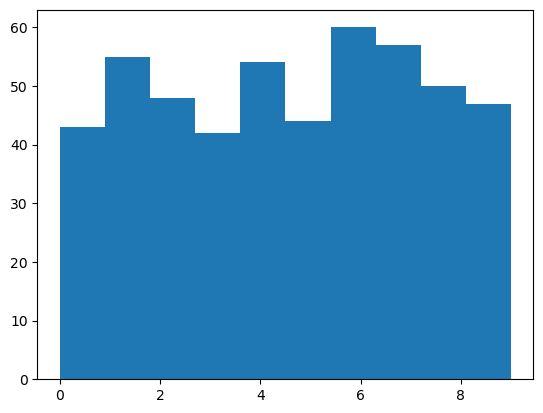

In [14]:
import matplotlib.pyplot as plt
plt.hist(y.cpu().numpy())

# Clustering

In [6]:
x_data = x_data_proper.reshape(x_data_proper.size(0), -1)
x_data /= x_data.norm(dim=1, keepdim=True)
sim_m = x_data @ x_data.T

In [7]:
def retrieve_info(cluster_labels, y_train):
    # Initializing
    unsolicited_ratio = 0.0
    denominator = 0.0
    reference_labels = {}
    # For loop to run through each label of cluster label
    for label in range(len(np.unique(y_train))):
        index = np.where(cluster_labels==label, 1, 0)
        dist = np.bincount(y_train[index==1])
        num = dist.argmax()
        unsolicited_ratio += (dist.sum() - dist.max())
        denominator += dist.sum()
        reference_labels[label] = num
    proper_labels = [reference_labels[label] for label in cluster_labels]
    proper_labels = np.array(proper_labels)
    unsolicited_ratio /= denominator
    return proper_labels, unsolicited_ratio

In [8]:
sim_m

tensor([[ 1.0000,  0.1775,  0.4387,  ...,  0.1344,  0.4152,  0.1767],
        [ 0.1775,  1.0000,  0.3079,  ...,  0.1010,  0.1005,  0.0557],
        [ 0.4387,  0.3079,  1.0000,  ..., -0.3433,  0.4382,  0.1425],
        ...,
        [ 0.1344,  0.1010, -0.3433,  ...,  1.0000,  0.0452,  0.1415],
        [ 0.4152,  0.1005,  0.4382,  ...,  0.0452,  1.0000,  0.1771],
        [ 0.1767,  0.0557,  0.1425,  ...,  0.1415,  0.1771,  1.0000]])

In [28]:
from sklearn.cluster import SpectralClustering 

similarity_matrix_ = sim_m.cpu().numpy()
labels_pred = SpectralClustering(n_clusters=10, affinity='precomputed', n_init=100, assign_labels='discretize').fit_predict((1+similarity_matrix_))

In [29]:
labels_pred, unsolicited_ratio = retrieve_info(labels_pred, y_data)
unsolicited_ratio

0.763

In [30]:
labels_pred

array([9, 1, 6, 2, 3, 1, 0, 0, 1, 1, 3, 8, 0, 2, 6, 6, 6, 0, 2, 0, 2, 2,
       0, 9, 8, 2, 8, 0, 0, 0, 8, 0, 6, 6, 2, 9, 2, 1, 0, 0, 0, 2, 6, 0,
       0, 2, 0, 0, 1, 2, 9, 0, 0, 0, 0, 0, 2, 2, 2, 6, 8, 0, 0, 2, 2, 1,
       9, 0, 0, 1, 1, 0, 0, 6, 9, 8, 9, 0, 0, 2, 3, 2, 0, 2, 0, 6, 9, 0,
       9, 0, 0, 8, 0, 0, 8, 0, 6, 8, 2, 6, 0, 2, 0, 2, 0, 3, 2, 0, 1, 8,
       0, 9, 0, 0, 8, 2, 0, 1, 6, 1, 0, 2, 2, 8, 3, 2, 3, 3, 2, 3, 8, 9,
       0, 1, 0, 8, 3, 8, 2, 0, 2, 3, 9, 2, 3, 9, 9, 8, 1, 3, 1, 0, 0, 2,
       8, 2, 0, 1, 0, 2, 1, 3, 3, 3, 0, 1, 0, 0, 1, 0, 9, 9, 6, 8, 6, 2,
       2, 8, 0, 2, 2, 2, 0, 9, 3, 1, 0, 9, 8, 9, 2, 1, 9, 0, 8, 0, 9, 0,
       8, 0, 9, 2, 3, 3, 0, 2, 2, 6, 9, 0, 0, 9, 8, 3, 3, 0, 9, 2, 8, 3,
       0, 0, 9, 0, 6, 0, 3, 2, 6, 9, 2, 1, 2, 0, 8, 2, 2, 9, 2, 0, 2, 1,
       0, 2, 8, 3, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 8, 2, 9, 1, 2, 3, 6,
       2, 6, 2, 2, 0, 3, 2, 6, 9, 8, 2, 8, 8, 3, 9, 6, 2, 0, 0, 2, 2, 2,
       2, 0, 6, 1, 6, 2, 0, 1, 0, 1, 9, 2, 6, 9, 0,

In [21]:
y_data_proper

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [30]:
acc = (labels_pred == y_data_proper.numpy()).astype(float).sum() / y_data_proper.shape[0]
acc

0.237

In [25]:
(labels_pred == y_data_proper.numpy())

array([ True, False, False,  True, False,  True, False, False,  True,
        True, False, False,  True,  True, False, False, False, False,
        True, False, False, False,  True, False, False, False,  True,
       False,  True, False,  True, False,  True,  True, False,  True,
       False, False, False,  True, False,  True,  True, False,  True,
       False, False, False, False, False, False,  True,  True, False,
        True, False, False,  True, False,  True, False,  True, False,
       False, False, False, False, False,  True, False,  True, False,
        True, False,  True, False,  True, False, False, False, False,
       False,  True, False, False,  True, False,  True, False,  True,
       False, False,  True,  True, False,  True, False, False, False,
        True,  True,  True,  True, False, False, False,  True, False,
        True, False, False, False, False,  True, False, False,  True,
       False,  True, False, False, False,  True, False,  True, False,
        True,  True,